<a href="https://colab.research.google.com/github/HenryMayta1/APP1/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib numpy pillow torchsummary tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import math
from torch.utils.tensorboard import SummaryWriter
import datetime
from torchsummary import summary
from torchvision.models.resnet import BasicBlock


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.6.0+cu124
False


In [4]:
# Configuración del dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
!unzip /content/datasets.zip -d /content/

Archive:  /content/datasets.zip
   creating: /content/datasets/
   creating: /content/datasets/train/
   creating: /content/datasets/train/ants/
  inflating: /content/datasets/train/ants/0013035.jpg  
  inflating: /content/datasets/train/ants/1030023514_aad5c608f9.jpg  
  inflating: /content/datasets/train/ants/1095476100_3906d8afde.jpg  
  inflating: /content/datasets/train/ants/1099452230_d1949d3250.jpg  
  inflating: /content/datasets/train/ants/116570827_e9c126745d.jpg  
  inflating: /content/datasets/train/ants/1225872729_6f0856588f.jpg  
  inflating: /content/datasets/train/ants/1262877379_64fcada201.jpg  
  inflating: /content/datasets/train/ants/1269756697_0bce92cdab.jpg  
  inflating: /content/datasets/train/ants/1286984635_5119e80de1.jpg  
  inflating: /content/datasets/train/ants/132478121_2a430adea2.jpg  
  inflating: /content/datasets/train/ants/1360291657_dc248c5eea.jpg  
  inflating: /content/datasets/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: /content/datasets/

In [6]:
# Definir las transformaciones para los conjuntos de datos de entrenamiento y validación
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [7]:
# Definir las rutas a los directorios de datos
data_dir = 'datasets/train'
val_dir = 'datasets/val'
# Define el porcentaje de datos a utilizar (por ejemplo, 50%)
portion_train = 1
portion_val = 1

# Cargar los conjuntos de datos de entrenamiento y validación
full_train_dataset = datasets.ImageFolder(data_dir, data_transforms['train'])
full_val_dataset = datasets.ImageFolder(val_dir, data_transforms['val'])

# Calcular el número de muestras a usar según el porcentaje
num_train_samples = int(len(full_train_dataset) * portion_train)
num_val_samples = int(len(full_val_dataset) * portion_val)

# Crear un subset de los datos
train_indices = torch.randperm(len(full_train_dataset)).tolist()[:num_train_samples]
val_indices = torch.randperm(len(full_val_dataset)).tolist()[:num_val_samples]

image_datasets = {
    'train': torch.utils.data.Subset(full_train_dataset, train_indices),
    'val': torch.utils.data.Subset(full_val_dataset, val_indices)
}

# Crear DataLoaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

# Obtener las clases
class_names = full_train_dataset.classes

# Obtener el tamaño de los conjuntos de datos
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
# Cargar un modelo pre-entrenado (ResNet18) y ajustar las últimas capas
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [9]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
# Función para entrenar el modelo
def train_model(model, criterion, optimizer, num_epochs=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    model.load_state_dict(best_model_wts)
    return model

In [11]:
# Entrenar el modelo
model = train_model(model, criterion, optimizer, num_epochs=5)
# Guardar el modelo entrenado
torch.save(model.state_dict(), 'model.pth')

Epoch 1/5
----------
train Loss: 0.9435 Acc: 0.5071
val Loss: 0.6444 Acc: 0.7062

Epoch 2/5
----------
train Loss: 0.5719 Acc: 0.7750
val Loss: 0.3092 Acc: 0.9096

Epoch 3/5
----------
train Loss: 0.3109 Acc: 0.9214
val Loss: 0.2081 Acc: 0.9435

Epoch 4/5
----------
train Loss: 0.2503 Acc: 0.9321
val Loss: 0.1733 Acc: 0.9492

Epoch 5/5
----------
train Loss: 0.1930 Acc: 0.9464
val Loss: 0.1545 Acc: 0.9492



In [12]:
# Función para predecir una imagen
def predict_image(image_path):
    model.eval()
    image = Image.open(image_path)
    image = data_transforms['val'](image).unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    return class_names[preds[0]]

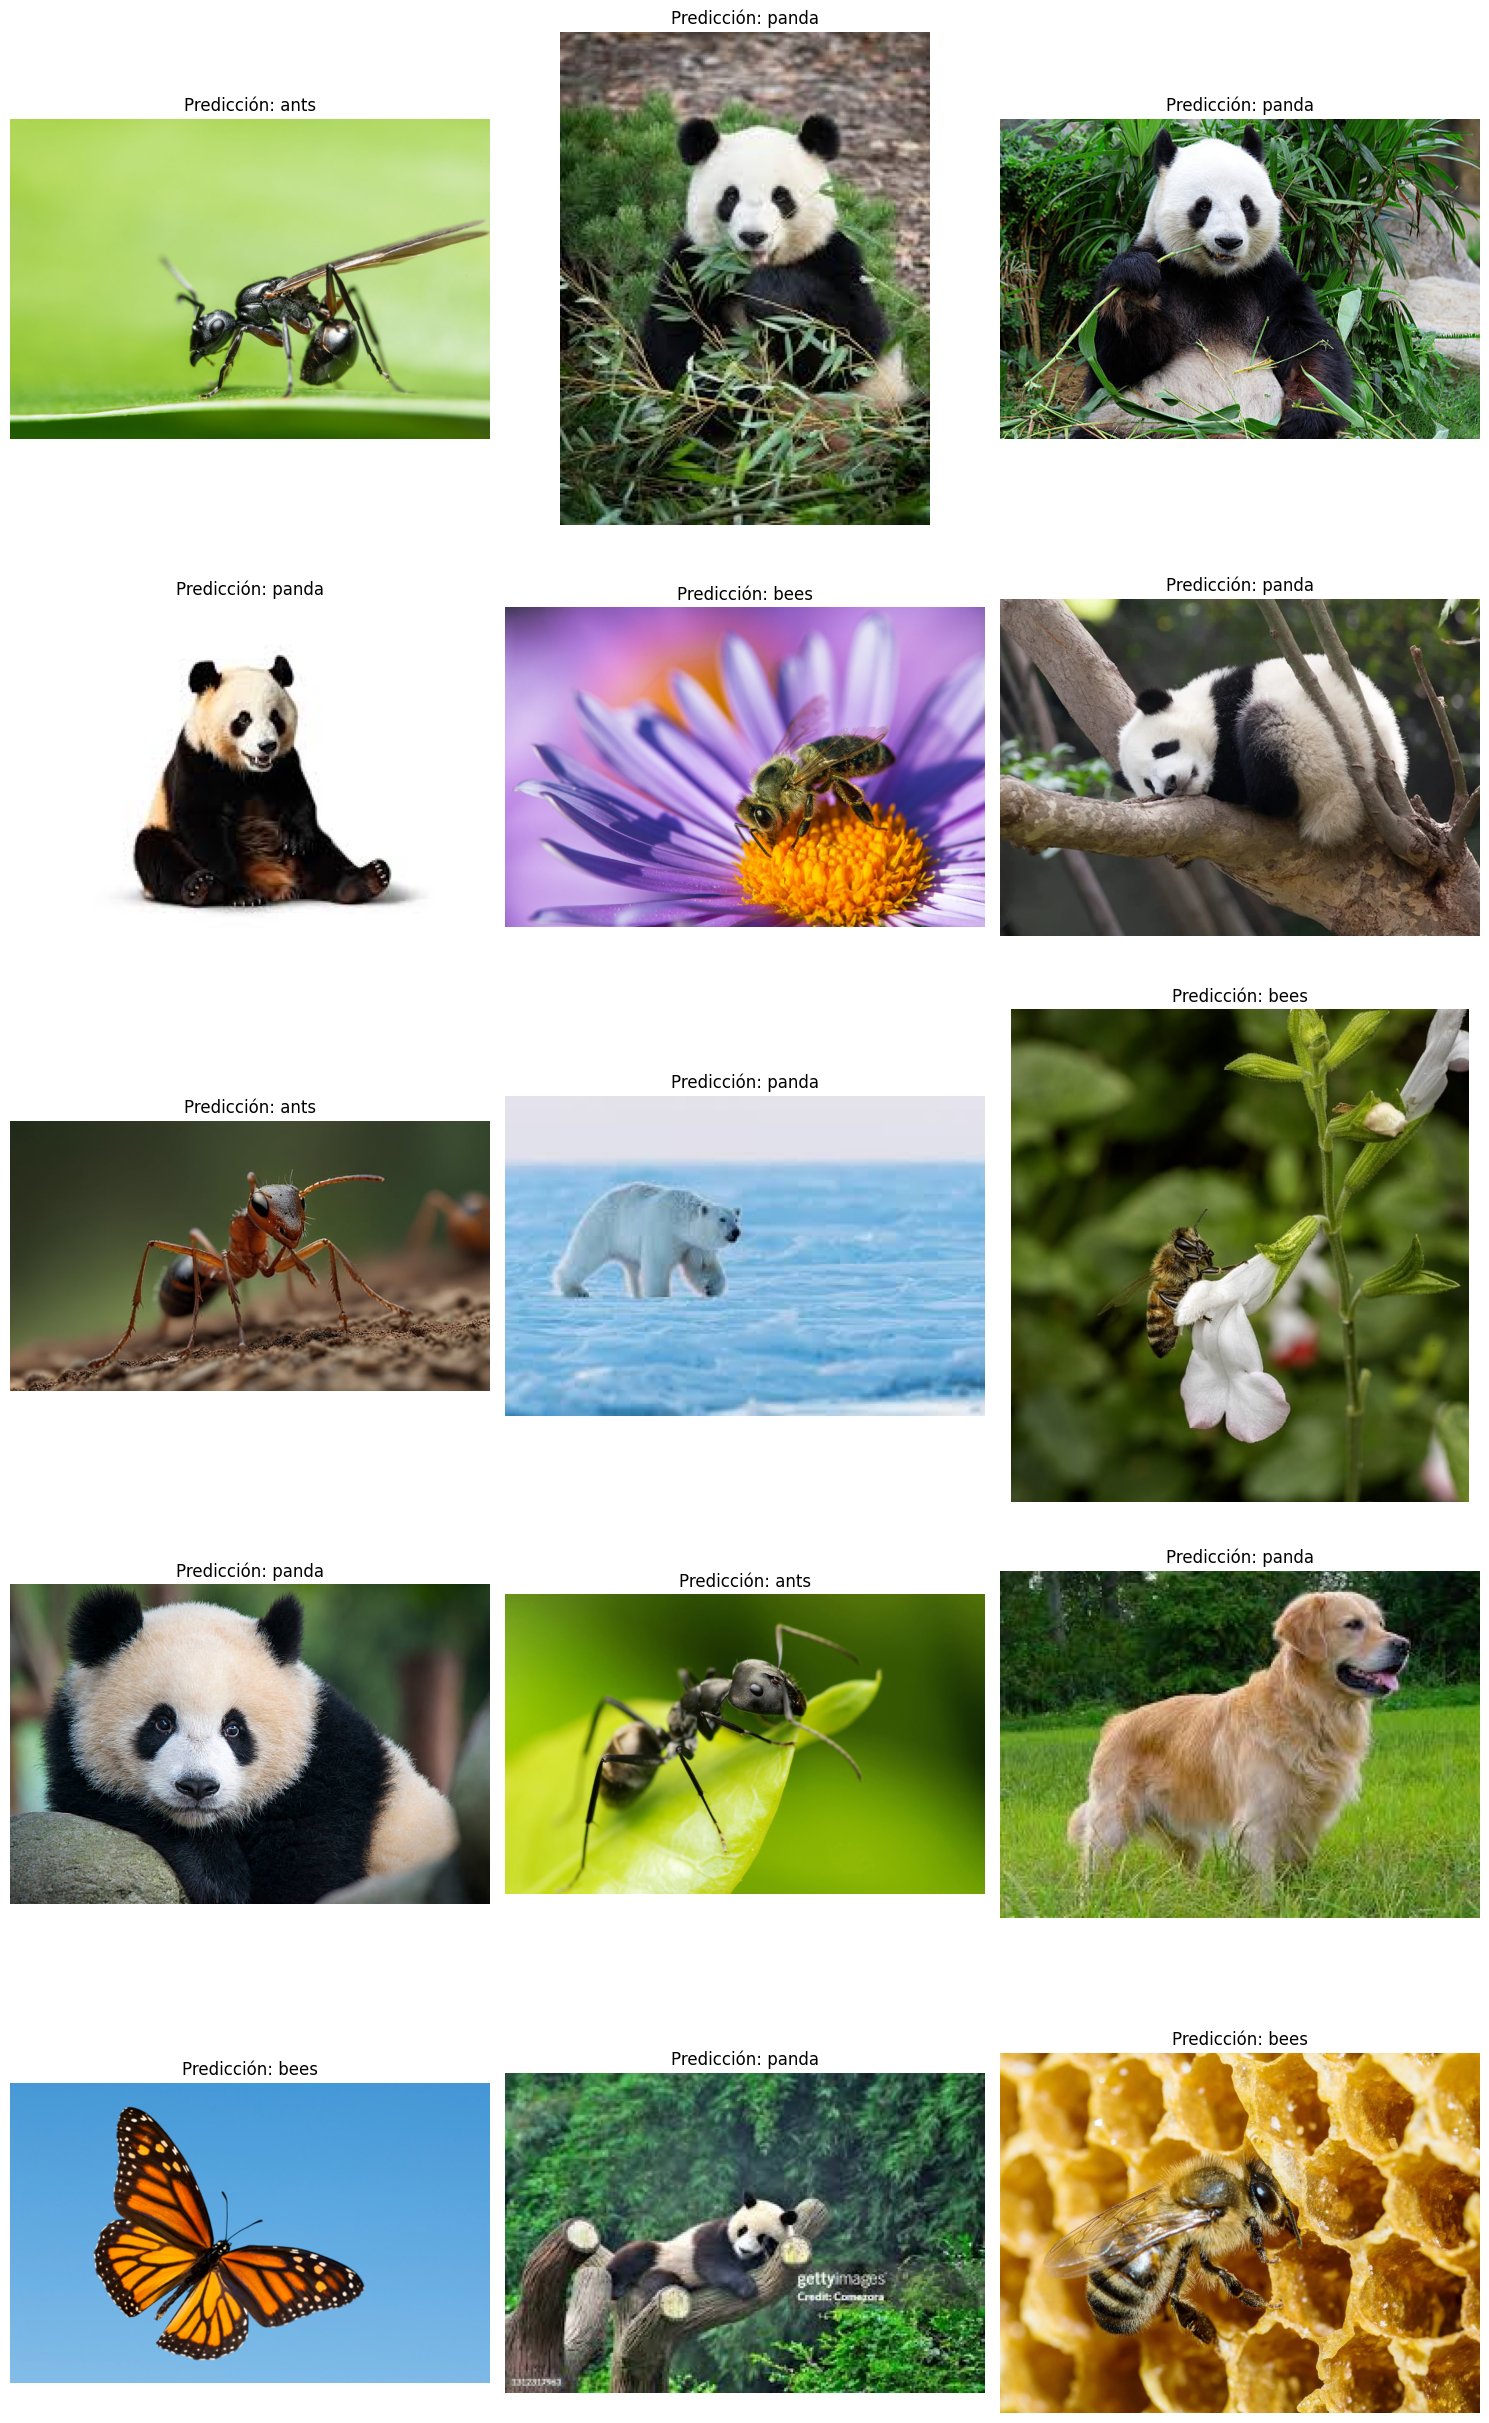

In [13]:

# Ruta a la carpeta que contiene las imágenes
folder_path = 'examples'

# Obtener una lista de todas las imágenes en la carpeta
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Número de imágenes
num_images = len(image_files)

# Calcular el número de filas y columnas para el mosaico
cols = 3  # Puedes ajustar esto para tener más o menos columnas
rows = math.ceil(num_images / cols)

# Crear una figura con subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Aplanar los ejes para iterar fácilmente si hay más de una fila
axes = axes.flatten()

# Iterar sobre las imágenes y mostrarlas en el mosaico
for i, filename in enumerate(image_files):
    image_path = os.path.join(folder_path, filename)

    # Hacer la predicción
    prediction = predict_image(image_path)

    # Abrir la imagen
    image = Image.open(image_path)

    # Mostrar la imagen junto con la predicción
    axes[i].imshow(image)
    axes[i].set_title(f'Predicción: {prediction}')
    axes[i].axis('off')

# Eliminar los ejes sobrantes si hay menos imágenes que subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()